In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import timedelta
from sklearn.metrics import root_mean_squared_error
import pickle
from pmdarima.arima import auto_arima
from prepare_data import PrepareData

c:\Users\krist\work\university\year2\semester2\data analysis\final-model\training\prepare_data.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("6H")


In [2]:
df = PrepareData.df
train_data = PrepareData.train_data()
test_data = PrepareData.test_data()

# Training sarima to predict the precipitation 

## EDA

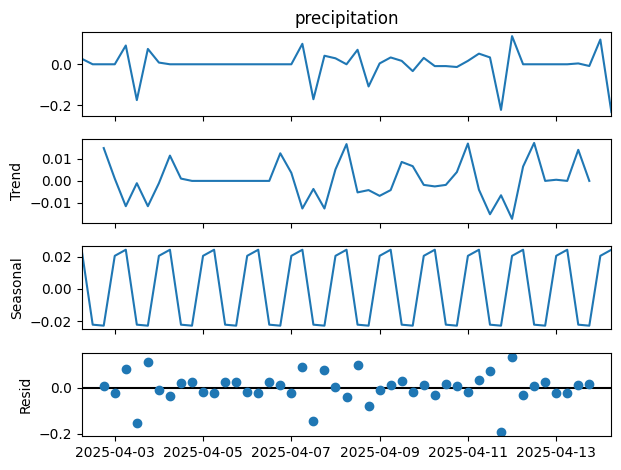

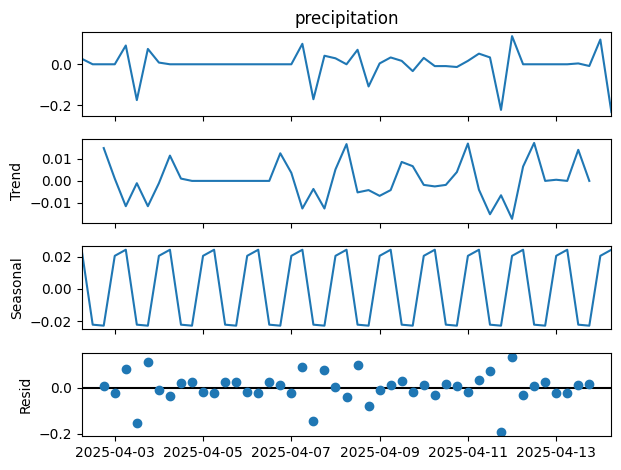

In [3]:
seasonal_decompose(
    df["precipitation"].diff().dropna().diff().dropna(), model="additive", period=4
).plot()

### Find the D parameter

In [4]:
result = adfuller(df["precipitation"].diff().dropna().diff().dropna(), autolag="AIC")
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print("Critial Values:")
    print(f"   {key}, {value}")

ADF Statistic: -4.01726853063941
p-value: 0.0013227390944617855
Critial Values:
   1%, -3.6155091011809297
Critial Values:
   5%, -2.941262357486514
Critial Values:
   10%, -2.6091995013850418


The model returns the p-value < 0.05, therefore, the d parameter must be 2.

### Find the P parameter

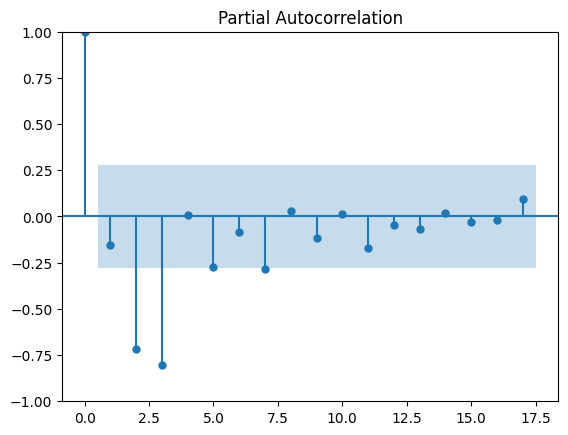

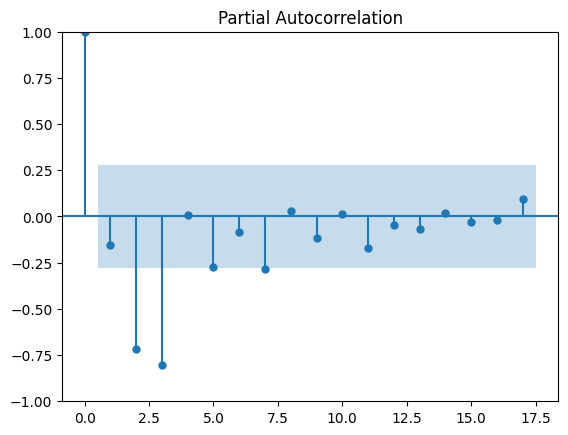

In [5]:
plot_pacf(df["humidity"].diff().dropna().diff().dropna())


The 4 lags in the front are the most influential, therefore, p = 4

### Find the Q parameter

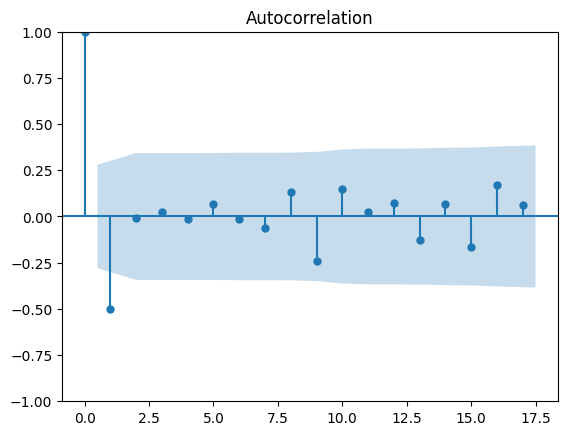

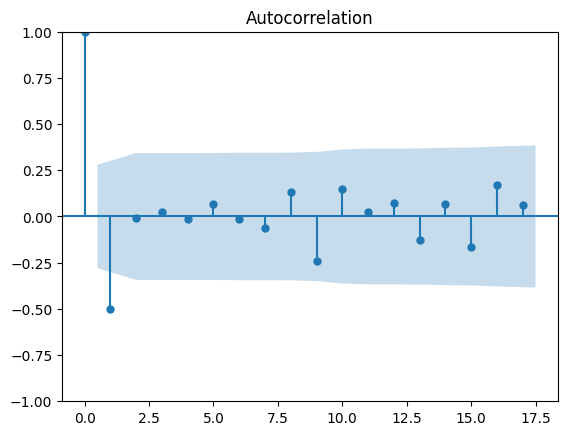

In [6]:
plot_acf(df["precipitation"].diff().dropna().diff().dropna())

The graph is not clear, therefore, the q parameter might be 0 or 1

## Pre-Processing

In [7]:
train_data["precipitation"] = train_data["precipitation"].ffill()
test_data["precipitation"] = test_data["precipitation"].ffill()

C:\Users\krist\AppData\Local\Temp\ipykernel_30240\43850155.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["precipitation"] = train_data["precipitation"].ffill()
C:\Users\krist\AppData\Local\Temp\ipykernel_30240\43850155.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["precipitation"] = test_data["precipitation"].ffill()


## Train the model

In [8]:
# Use auto_arima to find the best model parameters
model = auto_arima(
    train_data["precipitation"],
    seasonal=True,
    m=4,  # seasonality
    d=1,
    D=1,
    max_p=3,
    max_q=3,
    max_P=2,
    max_Q=2,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
)

c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[4]             : AIC=-79.914, Time=0.23 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=-67.518, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-78.807, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-85.953, Time=0.06 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=inf, Time=0.04 sec


c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.wa

 ARIMA(0,1,1)(1,1,1)[4]             : AIC=-85.495, Time=0.14 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=-86.291, Time=0.20 sec


c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,2)[4]             : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,1,2)[4]             : AIC=-81.083, Time=0.14 sec


c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,1,2)[4]             : AIC=-84.366, Time=0.20 sec


c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,1,2)[4]             : AIC=-83.385, Time=0.26 sec
 ARIMA(1,1,0)(0,1,2)[4]             : AIC=-82.921, Time=0.13 sec


c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,1,2)[4]             : AIC=-82.090, Time=0.25 sec


c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,2)[4] intercept   : AIC=inf, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,1,2)[4]          
Total fit time: 2.174 seconds


In [9]:
model_humidity = SARIMAX(
    endog=train_data["precipitation"],
    order=model.order,
    seasonal_order=model.seasonal_order,
)
humidity_results = model_humidity.fit()

humidity_prediction = humidity_results.get_forecast(
    steps=int(test_data["precipitation"].count())
).predicted_mean
forecast_index = pd.date_range(
    start=test_data.index[0],
    freq=timedelta(days=1),
    periods=int(test_data["precipitation"].count()),
)
humidity_prediction.columns = ["predicted"]

c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


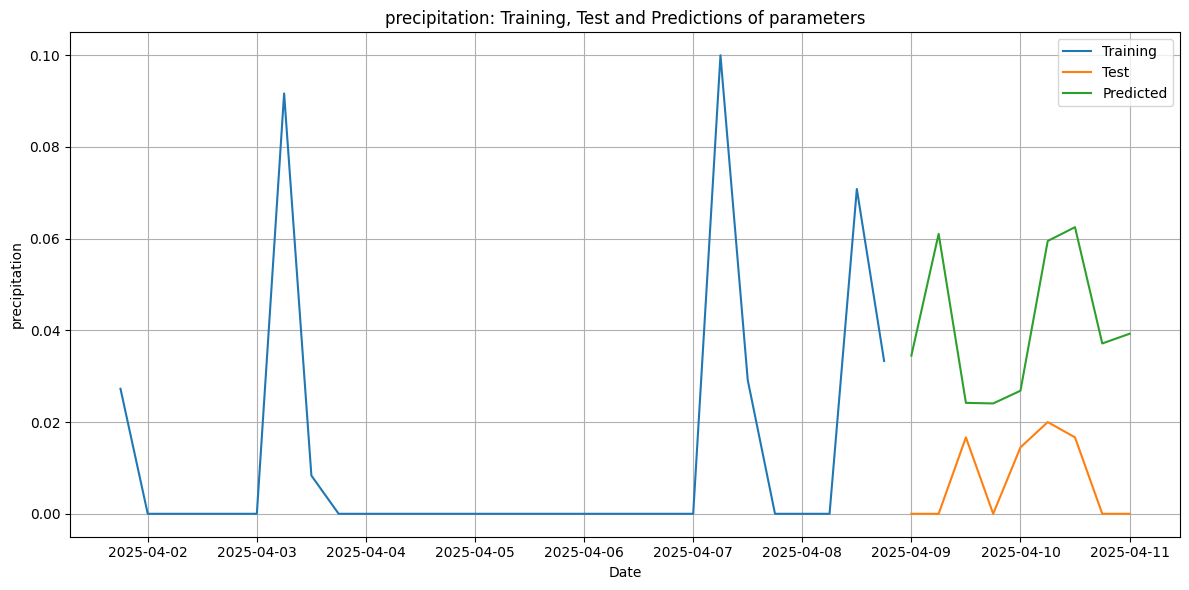

RMSE is :  0.03695247009820745


In [10]:
plt.figure(figsize=(12, 6))
# Ensure datetime index and proper plotting
plt.plot(train_data.index, train_data["precipitation"], label="Training")
plt.plot(test_data.index, test_data["precipitation"], label="Test")
plt.plot(
    test_data.index, humidity_prediction, label="Predicted"
)  # use the same x-axis as test

plt.legend()
plt.xlabel("Date")
plt.ylabel("precipitation")
plt.title("precipitation: Training, Test and Predictions of parameters")
plt.grid(True)
plt.tight_layout()
plt.show()

print(
    "RMSE is : ",
    root_mean_squared_error(test_data["precipitation"], humidity_prediction),
)

## Save the model using pickle

In [11]:
with open("../exports/precipitation_sarima.pkl", "wb") as file:
    pickle.dump(humidity_results, file)